In [1]:
import os
import torch
import transformers

HF_TOKEN = os.getenv("HF_TOKEN")

model_name = "meta-llama/Llama-3.2-3B-Instruct"

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    token=HF_TOKEN,
    output_hidden_states=True,  # Enable hidden states
)
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_name,
    token=HF_TOKEN,
)

print(model, model.config)

c:\Users\sewoo\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
      )
    )
    (norm

In [2]:
from src.util.json_io import *

train_qnas = load_jsonlines(f'data/gsm8k/train.jsonl')
test_qnas = load_jsonlines(f'data/gsm8k/test.jsonl')
len(train_qnas), len(test_qnas)

(7473, 1319)

In [3]:
import random; rseed = 42; random.seed(rseed)

nshot_prompt = f""
for i in random.sample(range(len(train_qnas)), 8):
    nshot_prompt += f"Question: {train_qnas[i]['question']}\nAnswer: {train_qnas[i]['answer']}\n\n"

print(nshot_prompt)

Question: For every 12 cans you recycle, you receive $0.50, and for every 5 kilograms of newspapers, you receive $1.50. If your family collected 144 cans and 20 kilograms of newspapers, how much money would you receive?
Answer: There are 144/12 = <<144/12=12>>12 sets of 12 cans that the family collected.
So, the family would receive $0.50 x 12 = $<<0.50*12=6>>6 for the cans.
There are 20/5 = <<20/5=4>>4 sets of 5 kilograms of newspapers that the family collected.
So, the family would receive $1.50 x 4 = $<<1.50*4=6>>6 for the newspapers.
Therefore, the family would receive a total of $6 + $6 = $<<6+6=12>>12.
#### 12

Question: Betty picked 16 strawberries. Matthew picked 20 more strawberries than Betty and twice as many as Natalie. They used their strawberries to make jam. One jar of jam used 7 strawberries and they sold each jar at $4. How much money were they able to make from the strawberries they picked?
Answer: Matthew picked 16 + 20 = <<16+20=36>>36 strawberries.
Natalie picked 3

In [4]:
def question_to_prompt(question):
    return f"{nshot_prompt}Question: {question} Let's think step by step.\nAnswer: "

sample_i = 4
print(question_to_prompt(test_qnas[sample_i]['question']))

from src.util.gsm8k_helper import *
test_qnas[sample_i]['answer'], extract_num_from_ans(test_qnas[sample_i]['answer'])

Question: For every 12 cans you recycle, you receive $0.50, and for every 5 kilograms of newspapers, you receive $1.50. If your family collected 144 cans and 20 kilograms of newspapers, how much money would you receive?
Answer: There are 144/12 = <<144/12=12>>12 sets of 12 cans that the family collected.
So, the family would receive $0.50 x 12 = $<<0.50*12=6>>6 for the cans.
There are 20/5 = <<20/5=4>>4 sets of 5 kilograms of newspapers that the family collected.
So, the family would receive $1.50 x 4 = $<<1.50*4=6>>6 for the newspapers.
Therefore, the family would receive a total of $6 + $6 = $<<6+6=12>>12.
#### 12

Question: Betty picked 16 strawberries. Matthew picked 20 more strawberries than Betty and twice as many as Natalie. They used their strawberries to make jam. One jar of jam used 7 strawberries and they sold each jar at $4. How much money were they able to make from the strawberries they picked?
Answer: Matthew picked 16 + 20 = <<16+20=36>>36 strawberries.
Natalie picked 3

('If each chicken eats 3 cups of feed per day, then for 20 chickens they would need 3*20=<<3*20=60>>60 cups of feed per day.\nIf she feeds the flock 15 cups of feed in the morning, and 25 cups in the afternoon, then the final meal would require 60-15-25=<<60-15-25=20>>20 cups of chicken feed.\n#### 20',
 20)

In [5]:
def generate_answer(input_text, verbose=False):
    input_ids = tokenizer.encode(
        input_text, 
        return_tensors='pt', 
    ).to(model.device)
    if verbose:
        print(f"input_ids shape: {input_ids.shape}")  # (1, sequence_length)

    with torch.no_grad():
        generated_outputs = model.generate(
            input_ids,
            max_length=input_ids.shape[1] + 512,  # maximum output length
            do_sample=True, top_k=1,  # greedy decoding (deterministic)
            eos_token_id=tokenizer.encode(text='\n\n', add_special_tokens=False)[0],
            pad_token_id=tokenizer.eos_token_id,
            return_dict_in_generate=True,
            output_hidden_states=True,  # Return hidden states
        )

    # generated_outputs.sequences (batch_size, generated_sequence_length)
    generated_tokens = generated_outputs.sequences[0]
    generated_text = tokenizer.decode(generated_tokens)
    generated_answer = generated_text.split('Answer: ')[-1].split(tokenizer.special_tokens_map['eos_token'])[0].split('\n\n')[0]
    if verbose:
        print(f"generated_outputs.sequences shape: {generated_outputs.sequences.shape}")  # (generated_sequence_length,)


    # generated_outputs.hidden_states: (generated_sequence_length, layer_num, batch_size, ?, hidden_dim)
    hidden_token_idx = -2
    if verbose:
        print(f"len(generated_outputs.hidden_states): {len(generated_outputs.hidden_states)}")
        print(f"len(generated_outputs.hidden_states[]): {len(generated_outputs.hidden_states[hidden_token_idx])}")
        print(f"generated_outputs.hidden_states[][].shape: {generated_outputs.hidden_states[hidden_token_idx][0].shape}")

    hidden_state_vector = generated_outputs.hidden_states[hidden_token_idx][-1][0][0]
    if verbose:
        print(f"hidden_state_vector shape: {hidden_state_vector.shape}")  # (hidden_dim,)
        print(f"token @ hidden_state_vector: {tokenizer.decode(generated_tokens[hidden_token_idx])}")

    return generated_answer, hidden_state_vector.cpu().numpy()

generated_answer, hidden_state_vector = generate_answer(question_to_prompt(test_qnas[sample_i]['question']), verbose=True)
print('\n=== Question ===\n', test_qnas[sample_i]['question'])
print('\n=== Ground Truth ===\n', test_qnas[sample_i]['answer'])
print('\n=== Generated ===\n', generated_answer)
print('\n=== Hidden State Vector Shape ===\n', hidden_state_vector.shape)

input_ids shape: torch.Size([1, 1425])


c:\Users\sewoo\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\llama\modeling_llama.py:655: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


generated_outputs.sequences shape: torch.Size([1, 1560])
len(generated_outputs.hidden_states): 135
len(generated_outputs.hidden_states[]): 29
generated_outputs.hidden_states[][].shape: torch.Size([1, 1, 3072])
hidden_state_vector shape: torch.Size([3072])
token @ hidden_state_vector: 20

=== Question ===
 Every day, Wendi feeds each of her chickens three cups of mixed chicken feed, containing seeds, mealworms and vegetables to help keep them healthy.  She gives the chickens their feed in three separate meals. In the morning, she gives her flock of chickens 15 cups of feed.  In the afternoon, she gives her chickens another 25 cups of feed.  How many cups of feed does she need to give her chickens in the final meal of the day if the size of Wendi's flock is 20 chickens?

=== Ground Truth ===
 If each chicken eats 3 cups of feed per day, then for 20 chickens they would need 3*20=<<3*20=60>>60 cups of feed per day.
If she feeds the flock 15 cups of feed in the morning, and 25 cups in the a

In [ ]:
from tqdm import tqdm

# Collect features and labels from training data
train_features = []
train_labels = []

print("Processing training data...")
for i, qna in enumerate(tqdm(train_qnas[:])): # Change here (e.g., qnas[:20]) for quick testing
    input_text = question_to_prompt(qna['question'])
    generated_answer, hidden_state_vector = generate_answer(input_text)
    generated_answer_int = extract_num_from_ans(generated_answer)
    ground_truth_int = extract_num_from_ans(qna['answer'])

    label = int(generated_answer_int == ground_truth_int)
    train_features.append(hidden_state_vector)
    train_labels.append(label)

print(f"Collected {len(train_features)} training samples.")

Processing training data...
Collected 7473 training samples.


In [ ]:
from tqdm import tqdm

# Collect features and labels from test data
test_features = []
test_labels = []

print("Processing test data...")
for i, qna in enumerate(tqdm(test_qnas[:])): # Change here (e.g., qnas[:20]) for quick testing
    input_text = question_to_prompt(qna['question'])
    generated_answer, hidden_state_vector = generate_answer(input_text)
    generated_answer_int = extract_num_from_ans(generated_answer)
    ground_truth_int = extract_num_from_ans(qna['answer'])

    label = int(generated_answer_int == ground_truth_int)
    test_features.append(hidden_state_vector)
    test_labels.append(label)

print(f"Collected {len(test_features)} test samples.")

Processing test data...
Collected 1319 test samples.


In [8]:
import numpy as np

train_features = np.array(train_features)
train_labels = np.array(train_labels)
test_features = np.array(test_features)
test_labels = np.array(test_labels)

print("Training feature shape:", train_features.shape)
print("Test feature shape:", test_features.shape)

Training feature shape: (7473, 3072)
Test feature shape: (1319, 3072)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
import numpy as np

# Initialize and train the classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(train_features, train_labels)

# Evaluate on test data
test_predictions = clf.predict(test_features)
clf_accuracy = np.mean(test_predictions == test_labels)
clf_f1 = f1_score(test_labels, test_predictions, average='weighted')  # 'weighted' average handles class imbalance

# Print the results
print(f"Probing Accuracy: {clf_accuracy * 100:.2f}%")
print(f"Probing F1 Score: {clf_f1:.2f}")

Test Accuracy: 73.01%


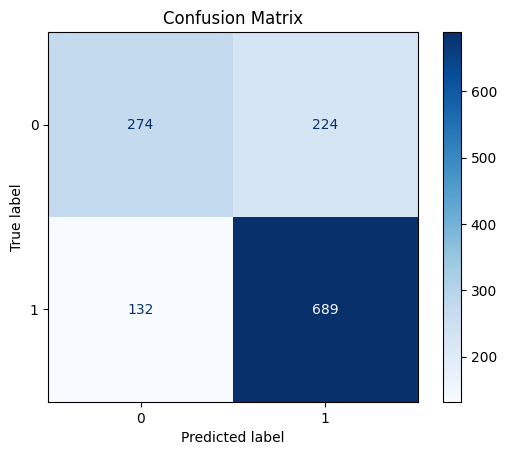

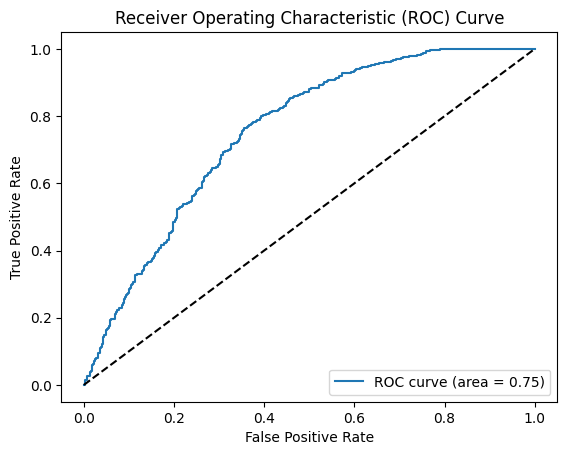

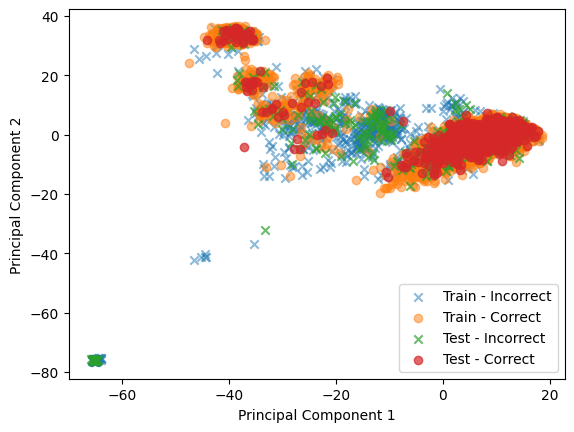

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.decomposition import PCA

# 1. Confusion Matrix
test_predictions = clf.predict(test_features)
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# 2. ROC Curve
probs = clf.predict_proba(test_features)[:, 1]  # Positive class probabilities
fpr, tpr, _ = roc_curve(test_labels, probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# 3. PCA-based 2D Visualization
# Dimension reduction to 2D using PCA
pca = PCA(n_components=2)
train_features_2d = pca.fit_transform(train_features)
test_features_2d = pca.transform(test_features)

# Visualize training data
plt.scatter(train_features_2d[train_labels == 0][:, 0], train_features_2d[train_labels == 0][:, 1], 
            label="Train - Incorrect", marker='x', alpha=0.5)
plt.scatter(train_features_2d[train_labels == 1][:, 0], train_features_2d[train_labels == 1][:, 1], 
            label="Train - Correct", marker='o', alpha=0.5)

# Visualize test data
plt.scatter(test_features_2d[test_labels == 0][:, 0], test_features_2d[test_labels == 0][:, 1], 
            label="Test - Incorrect", marker='x', alpha=0.7)
plt.scatter(test_features_2d[test_labels == 1][:, 0], test_features_2d[test_labels == 1][:, 1], 
            label="Test - Correct", marker='o', alpha=0.7)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()


import os
os.makedirs("outputs", exist_ok=True)
plt.savefig(f"outputs/2d_pca_visualization-{model_name.split('/')[-1]}.pdf")

plt.show()


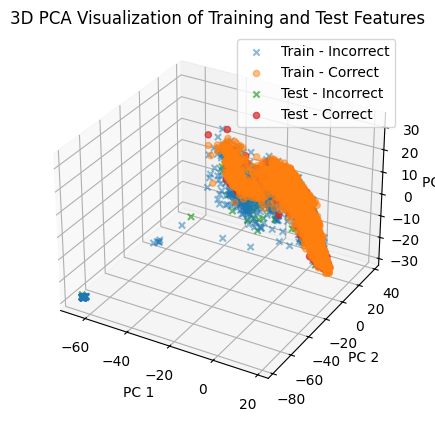

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# 3D PCA-based Visualization with different markers for correct and incorrect
pca_3d = PCA(n_components=3)
train_features_3d = pca_3d.fit_transform(train_features)
test_features_3d = pca_3d.transform(test_features)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Visualize training data in 3D
ax.scatter(train_features_3d[train_labels == 0][:, 0], train_features_3d[train_labels == 0][:, 1], train_features_3d[train_labels == 0][:, 2], 
           label="Train - Incorrect", marker='x', alpha=0.5)
ax.scatter(train_features_3d[train_labels == 1][:, 0], train_features_3d[train_labels == 1][:, 1], train_features_3d[train_labels == 1][:, 2], 
           label="Train - Correct", marker='o', alpha=0.5)

# Visualize test data in 3D
ax.scatter(test_features_3d[test_labels == 0][:, 0], test_features_3d[test_labels == 0][:, 1], test_features_3d[test_labels == 0][:, 2], 
           label="Test - Incorrect", marker='x', alpha=0.7)
ax.scatter(test_features_3d[test_labels == 1][:, 0], test_features_3d[test_labels == 1][:, 1], test_features_3d[test_labels == 1][:, 2], 
           label="Test - Correct", marker='o', alpha=0.7)

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title("3D PCA Visualization of Training and Test Features")
ax.legend()
plt.show()
